# Galaxies and the large-scale structure of the Universe

_A python exercise notebook written by Rita Tojeiro, October 2017, for the Lab component of the AS1001 Cosmology module at the University of St Andrews, UK. It has been slightly modified to stand alone in an SDSS EPO workshop at AAS. 
This notebook has benefited from examples provided by Britt Lundgren (University of North Carolina) and Jordan Raddick (John Hopkins University)_.

In this Notebook, you will use data from the Sloan Digital Sky Survey (SDSS), to explore the relationship between galaxy properties and the large-scale structure of the Universe. 

In the end, you should have found an answer to the following questions:

- How are galaxies spatially distributed in the Universe?
- Are galaxies all the same colour?
- Are galaxies all the same shape?
- How are galaxies' colours and shapes related to their spacial distribution?


## SDSS and SciServer

You will answer the above questions yourself, by exploring the largest astronomical dataset in the world - the Sloan Digital Sky Survey (www.sdss.org).

You will interact directly with the data using SciServer. SciServer is a cloud-based computing service, that allows users to query the SDSS database, store data in the cloud, and offers seamless integration with python programming tools via notebooks. In practice, this means that you can access and manipulate the largest astronomical dataset in the world, using only a web browser.

If you're reading this, you have already followed the instructions to get an account on SciServer, and have uploaded this notebook. These exercise assume that you are familiar with basic python, dataframe manipulation, and matplotlib commands.




### Imports

Firstly, we will import the necessary SciServer and support libraries. 

In [1]:
# Import Python libraries to work with SciServer
import SciServer.CasJobs as CasJobs # query with CasJobs
import SciServer.SciDrive as SciDrive   # read/write to/from SciDrive
import SciServer.SkyServer as SkyServer   # show individual objects and generate thumbnail images through SkyServer
print('SciServer libraries imported')

# Import other libraries for use in this notebook.
import numpy as np                  # standard Python lib for math ops
from imageio import imwrite         # save images as files
import pandas                       # data manipulation package
import matplotlib.pyplot as plt     # another graphing package
import os                           # manage local files in your Compute containers
print('Supporting libraries imported')

#import astroML
#from astroML.datasets import fetch_sdss_spectrum
from astropy.io import ascii

# Apply some special settings to the imported libraries
# ensure columns get written completely in notebook
pandas.set_option('display.max_colwidth', None)
# do *not* show python warnings 
import warnings
warnings.filterwarnings('ignore')
print('Settings applied')

SciServer libraries imported
Supporting libraries imported
Settings applied


## Querying the SDSS database

The SDSS data is stored in a SQL database. SQL is a languased used to communicate with databases via "queries". For each query command, the database returns an answer. Usually, this is a subsample of the original database, though SQL can operate on the data very effectively too. In this tutorial we will submit queries to the SDSS database to gather the information that we need, and we will use python to operate on, manipulate, and vizualise that data.

An extensive tutorial on how to query the SDSS database is provided here: http://skyserver.sdss.org/dr14/en/help/howto/search/searchhowtohome.aspx . In short, every SQL command consists of three blocks: 
- The **SELECT** block: it defines the quantities that you want your query to return.
- The **FROM** block: it defines which tables of the database you want SQL to look in.
- The **WHERE** block: it defines any constraints on the data that you want to impose.

In this Lab you won't have to write SQL queries from scratch, only execute commands that are already written for you.

### Using SQL and SciServer to return galaxy data

For the database schema and documentation see http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx The following query returns specific information on a sample of galaxies, as a dataframe.


In [2]:
# Find objects in the Sloan Digital Sky Survey's Data Release 14.
#
# Query the Sloan Digital Sky Serveys' Data Release 14.
# For the database schema and documentation see http://skyserver.sdss.org/dr14
#
# This query finds all galaxies with a size (petror90_r) greater than 10 arcseconds, within
# a region of sky with 100 < RA < 250, a redshift between 0.02 and 0.5, and a g-band magnitude brighter than 17.
# 
# First, store the query in an object called "query"
query="""
SELECT p.objId,p.ra,p.dec,p.petror90_r, p.expAB_r,
    p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i, 
    s.z, s.plate, s.mjd, s.fiberid
FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE p.petror90_r > 10
  and p.ra between 100 and 250
  and s.z between 0.02 and 0.5
  and p.g < 17
"""
#Then, query the database. The answer is a table that is being returned to a dataframe that we've named all_gals.
all_gals = CasJobs.executeQuery(query, "dr16")

print("SQL query finished.")
print("SQL query returned " + str(len(all_gals))+ " galaxies")

SQL query finished.
SQL query returned 40332 galaxies


The dataframe that is returned, which we named all_gals, holds the following quantities (in columns) for each galaxy:

- ra = Right Ascencion coordinate in degrees
- dec = Declination coordinate in degrees
- petror90_r = Radius enclosing 90% of the pertrosian flux in arcseconds. I.e., size of the galaxy in the sky.
- dered_u, dered_g, dered_r, dered_i, dered_z = Magnitudes in 5 optical filters, from the blue to the red, after subtracting the attenuation due to the Milky Way.
- z = Redshift of the galaxy
- plate = Plate number (SDSS used alluminium plates with drilled holes for positioning optical fibers).
- mjd = Date of the observation
- fiberid = Number of the fiber in a given plate. Plates have between 640 and 1000 fibers.

Let's have a look at the first 10 elements of the returned table (dataframe):

In [3]:
all_gals[0:10]

objId          ra       dec  petror90_r   expAB_r         u  \
0  1237650761316368451  179.002400 -2.720055  29.90478    0.860130  16.59324   
1  1237650761316630665  179.547287 -2.824468  13.19722    0.657813  18.24962   
2  1237650761317154966  180.794537 -2.875998  14.52145    0.754407  17.10954   
3  1237650761318203506  183.201106 -2.724620  16.49348    0.577123  16.82479   
4  1237650761318924495  184.897742 -2.830607  10.40758    0.487816  16.72573   
5  1237650761320104102  187.573846 -2.781192  12.27688    0.512899  17.78006   
6  1237650761320300733  187.989278 -2.866398  17.38497    0.325317  17.14486   
7  1237650761321152746  189.951562 -2.796089  13.66831    0.733589  17.46248   
8  1237650761322332240  192.676847 -2.825408  10.70972    0.583854  16.57590   
9  1237650761322594377  193.224624 -2.841215  12.95675    0.663679  17.49612   

          g         r         i         z  plate    mjd  fiberid  
0  15.22027  14.61850  14.33093  0.020307  330    52370  69       
1  16.37590  15.45398  15.01798  0.080837  331    52368  267      
2  15.14576  14.27486  13.84731  0.052211  331    52368  112      
3  15.13233  14.29979  13.86673  0.038072  332    52367  105      
4  15.80091  15.42693  15.24716  0.021523  333    52313  178      
5  16.11366  15.35365  14.95448  0.071384  334    51993  112      
6  16.01053  15.56320  15.34717  0.024349  334    51993  28       
7  15.64403  14.82956  14.43514  0.047938  335    52000  152      
8  15.43610  14.79491  14.40804  0.047116  337    51997  221      
9  15.98385  15.19366  14.77489  0.084437  338    51694  313

## The large scale structure of the Universe 

### Exercise:

1. Plot the positions of all galaxies usint plt.scatter(). Remember to add labels and a title to your plot. Given the large number of points, you might want to use marker='.' and s=1.

2. What can you tell from the distribution of galaxies? Are they uniformly distributed on the sky?

(-5, 70)

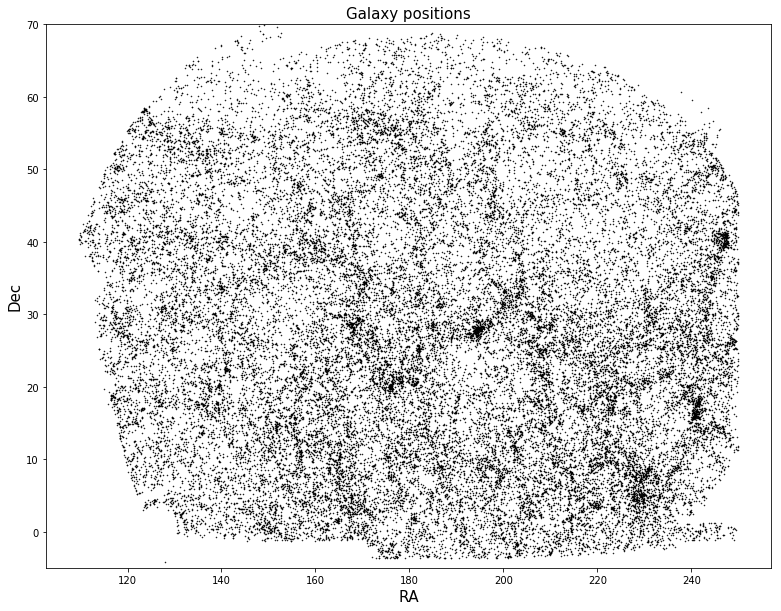

In [4]:
#Possible solution
plt.figure(figsize=(13,10))
plt.scatter(all_gals['ra'], all_gals['dec'], marker='.', color='black',s=1)
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions', fontsize=15)
plt.ylim(-5,70)

Possible solution: Students should note that the spacial distribution isn't uniform on the sky, with some regions showing a higher density of objects.


### Exercise: 

Using the np.where() command, select galaxies in two narrow redshift slices:
- slice 1: 0.02 < z < 0.03 (green)
- slice 2: 0.03 < z < 0.04 (orange)

Make the same plot as above, but only using the galaxies in each slice using the suggested colour scheme (make one plot for each slice). Finally, make a third plot with galaxies from both redshift slices. Add axis labels, a title and an legend to each plot.


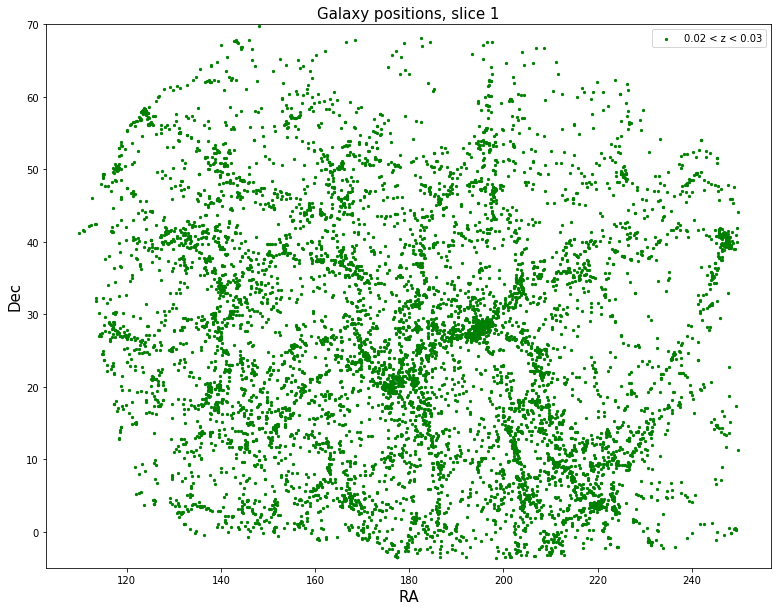

In [5]:
#Possible solution
plt.figure(figsize=(13,10))

slice1 = np.where( (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03))[0]

plt.scatter(all_gals.loc[slice1]['ra'], all_gals.loc[slice1]['dec'], color='green', marker='.', s=20, label='0.02 < z < 0.03')
plt.ylim(-5,70)
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions, slice 1', fontsize=15)
plt.legend()

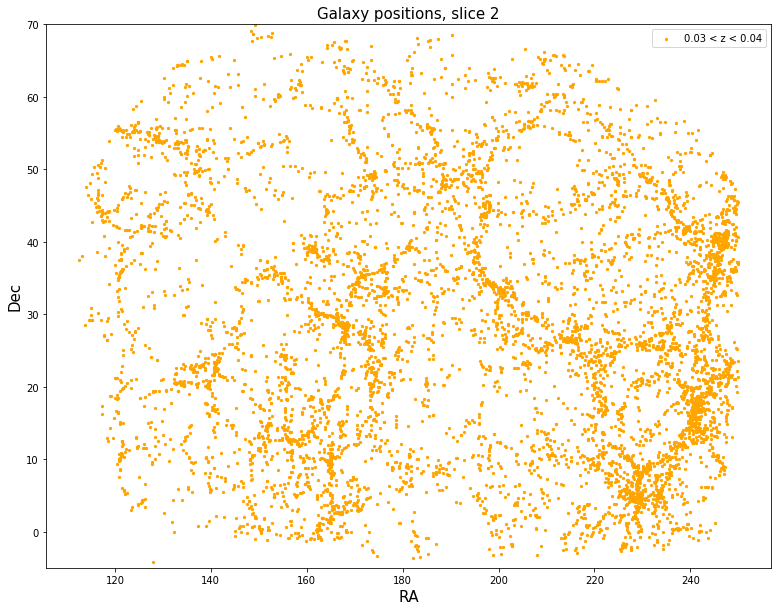

In [6]:
#possible solution
plt.figure(figsize=(13,10))

slice2 = np.where( (all_gals.z > 0.03) & (all_gals.z < 0.04))[0]
plt.scatter(all_gals.loc[slice2]['ra'], all_gals.loc[slice2]['dec'], color='orange', marker='.', s=20, label='0.03 < z < 0.04')
plt.ylim(-5,70)
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions, slice 2', fontsize=15)
plt.legend()

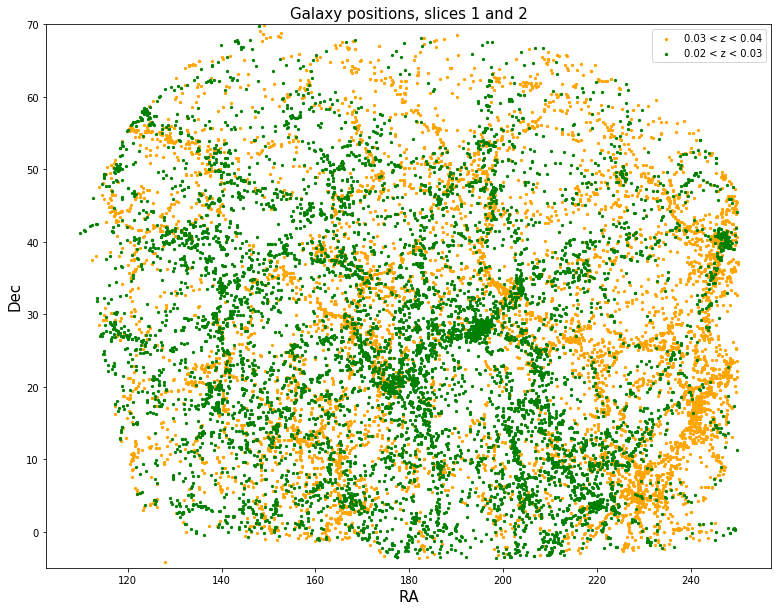

In [7]:
#possible solution
plt.figure(figsize=(13,10))

plt.scatter(all_gals.loc[slice2]['ra'], all_gals.loc[slice2]['dec'], color='orange', marker='.', s=20, label='0.03 < z < 0.04')
plt.scatter(all_gals.loc[slice1]['ra'], all_gals.loc[slice1]['dec'], color='green', marker='.', s=20, label='0.02 < z < 0.03')
plt.xlabel('RA', fontsize=15); plt.ylabel('Dec', fontsize=15)
plt.title('Galaxy positions, slices 1 and 2', fontsize=15)
plt.ylim(-5,70)
plt.legend()

### Exercise:

Do you see more structure in the distribution of galaxies in each slice, when compared to your first plot that included all galaxies? 

What can you tell about the structure you see in the two different redshift slices?

Why couldn't you see it in your first plot?

Possible answer:

A more filamentary structure connecting regions very high galaxy density (nodes, or knots) is now visible, with clear voids (regions with less galaxies) in between filaments. The filaments in the two redshift slices are often different because we are looking at different regions of space. The reason why filaments and voids becomes more prominent when we look at thin redshift slices is because if we use a wide range in redshift we overlap lots of different filaments and structure, blurring out the Universe's cosmic web.


## Galaxy colours

You will see in lectures that the optical colours of galaxies are related to the age of their stars - red galaxies hold older (redder, cooler) stars, whereas blue galaxies tend to have younger (bluer, hotted) stars. In practice, we can quantify "colour" in Astronomy as _the difference in magnitude in two different bands_.

The final exercises in the first notebook (SciServerLab_session1) give you a demonstration of how colours work in practice, and how the shape of the spectrum of a galaxy. We didn't consider it in the first notebook, but redshift can also affect the observed colour of galaxies (you will learn this in the later lectures, if you haven't yet). 

In this set of exercises **we will focus on the first slice in redshift**, which is very narrow, meaning that all galaxies have a similar redshift. I.e., if galaxies in this redshift slice have different colours, _it ought to be because their spectra and stellar composition are different_, and not because some are redshifted due to the expansion of the Universe. 

The following cell plots a histogram of the values of the **u-g colour** of the galaxies in your dataframe:

Text(0.5,1,'Distribution of u-g color in 0.02 < z < 0.03')

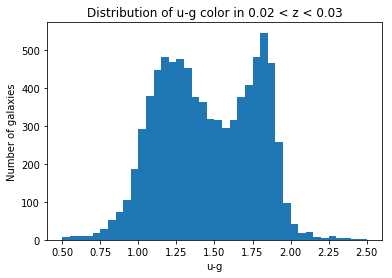

In [8]:
slice1 = np.where( (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03))[0]

plt.hist(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], bins=40, range=(0.5,2.5))
plt.xlabel('u-g')
plt.ylabel('Number of galaxies')
plt.title('Distribution of u-g color in 0.02 < z < 0.03')

**np.percentile()** (https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html) allows you to quickly return the percentile of a distribution of points. For example, to find the median (50th percentile) u-g colour of your galaxy population you can write:

In [9]:
median_umg = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 50)
print(median_umg)

1.4351650000000005


i.e., 50% of the galaxies in your sample have u-g colours that are lower than median_umg (i.e., they are bluer than the median), and 50% have  colours that are larger (i.e., they are redder than the median). If I wanted to choose only the 10% reddest galaxies I could do:

In [10]:
high_umg = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 90)

very_red_galaxies = np.where((all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & 
                                (all_gals['u']-all_gals['g'] > high_umg))

### Exercise:

Use np.percentile() to choose the 25% reddest and 25% bluest galaxies in u-g. Then plot their positions on the sky. Do both types of galaxies trace the large-scale structure in a similar way? What can you say about which galaxies preferencially sit on denser parts of the Universe, and which sit on less dense regions (we call this _environment_)? For this exercise it is recommended that you make two plots (one for the red galaxies, and one for the blue), but that you put them side by side to help you compare.


In [11]:
#possible answer
low_umg = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 25)
high_umg = np.percentile(all_gals.loc[slice1]['u']-all_gals.loc[slice1]['g'], 75)

(-5, 70)

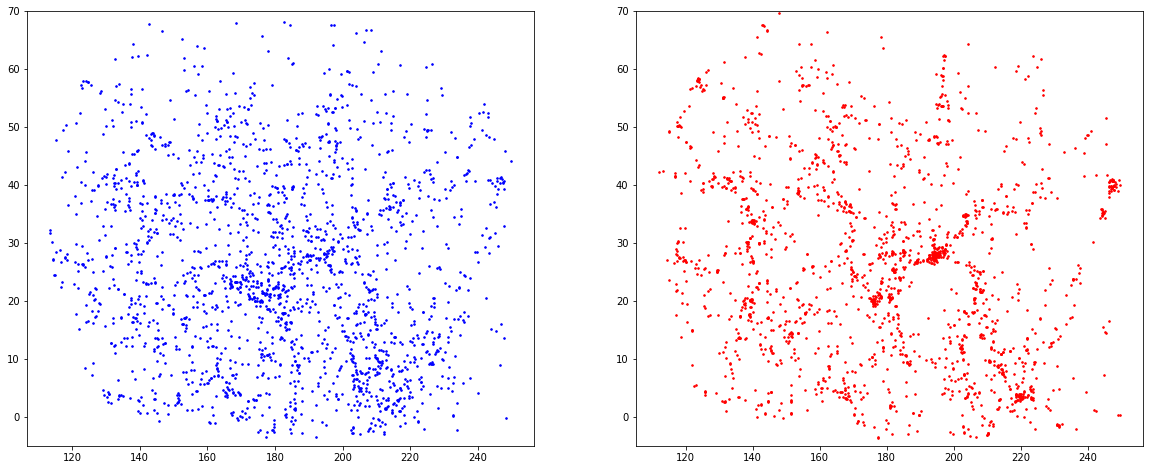

In [12]:
#possible answer
very_red_galaxies = (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & (all_gals['u']-all_gals['g'] > high_umg)
very_blue_galaxies = (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03) & (all_gals['u']-all_gals['g'] < low_umg)

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(all_gals.loc[very_blue_galaxies]['ra'], all_gals.loc[very_blue_galaxies]['dec'],  marker='.', s=10, color='blue')
plt.ylim(-5,70)

plt.subplot(122)
plt.scatter(all_gals.loc[very_red_galaxies]['ra'], all_gals.loc[very_red_galaxies]['dec'],  marker='.', s=10, color='red')
plt.ylim(-5,70)



By now you will have started developing an understanding of how galaxies in general are spacially distributed in the Universe and the shape of the cosmic web, and how galaxies' position on the cosmic web and their environment is related to their colour. Next, we will look at the **shape** of galaxies.

## Galaxy morphology

Galaxy morphology studies the shapes of galaxies. You will already have some understanding of how local galaxies look like, from your exploration of SDSS imaging in the first Lab session using the SDSS SkyServer Navigate Tool. 

Here, we will do a more systematic exploration of how galaxy shapes are related to other properties.

The next cell provides a bit of code that selects 16 **random** galaxies from your dataframe, and shows you their optical images.

In [13]:
def show_galaxy_images(my_galaxies):
    #plot a random subset of 16 galaxies
    # set thumbnail parameters
    width=200           # image width
    height=200          # height
    pixelsize=0.396     # image scale
    plt.figure(figsize=(15, 15))   # display in a 4x4 grid
    subPlotNum = 1


    i = 0
    nGalaxies = 16 #Total number of galaxies to plot
    ind = np.random.randint(0,len(my_galaxies), nGalaxies) #randomly selected rows
    count=0
    for i in ind:           # iterate through the randomly selected rows in the DataFrame
        count=count+1
        print('Getting image '+str(count)+' of '+str(nGalaxies)+'...')
        if (count == nGalaxies):
            print('Plotting images...')
        scale=2*all_gals.loc[i]['petror90_r']/pixelsize/width
        img = SkyServer.getJpegImgCutout(ra=all_gals.loc[my_galaxies[i]]['ra'], dec=all_gals.loc[my_galaxies[i]]['dec'], width=width, height=height, scale=scale,dataRelease='DR14')
        plt.subplot(4,4,subPlotNum)
        subPlotNum += 1
        plt.imshow(img)                               # show images in grid
        plt.title(all_gals.loc[my_galaxies[i]]['z'])     

You can use the function defined above to plot 16 _random_ galaxies from any dataframe. For example, to plot 16 galaxies randomly selected in a redshift slice 0.02 < z < 0.03 you might do:

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


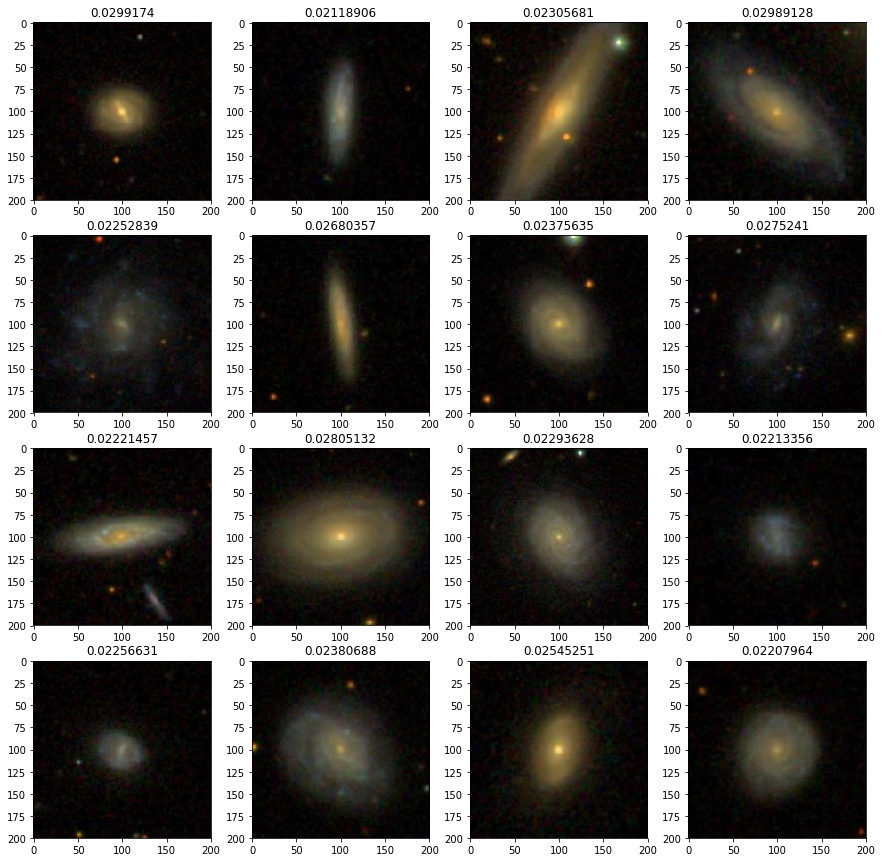

In [14]:
my_galaxies = np.where( (all_gals['z'] > 0.02) & (all_gals['z'] < 0.03))[0]
show_galaxy_images(my_galaxies)

### Exercise:
Compute the fraction of galaxies you'd classify as having disks, and the fraction of galaxies you'd classify as being smooth ellipsoids. Do this classification by eye. If you want to improve your statistics, you can rerun the cell above and you will get 16 different galaxies every time...

### Exercise:
Now starting from the code given in the example above (copy it and paste it onto the cell below), do the same thing but taking 16 random galaxies that are **red**, according to your earlier definition of red and blue. Once again, classify the galaxies as disks or ellipticals.

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


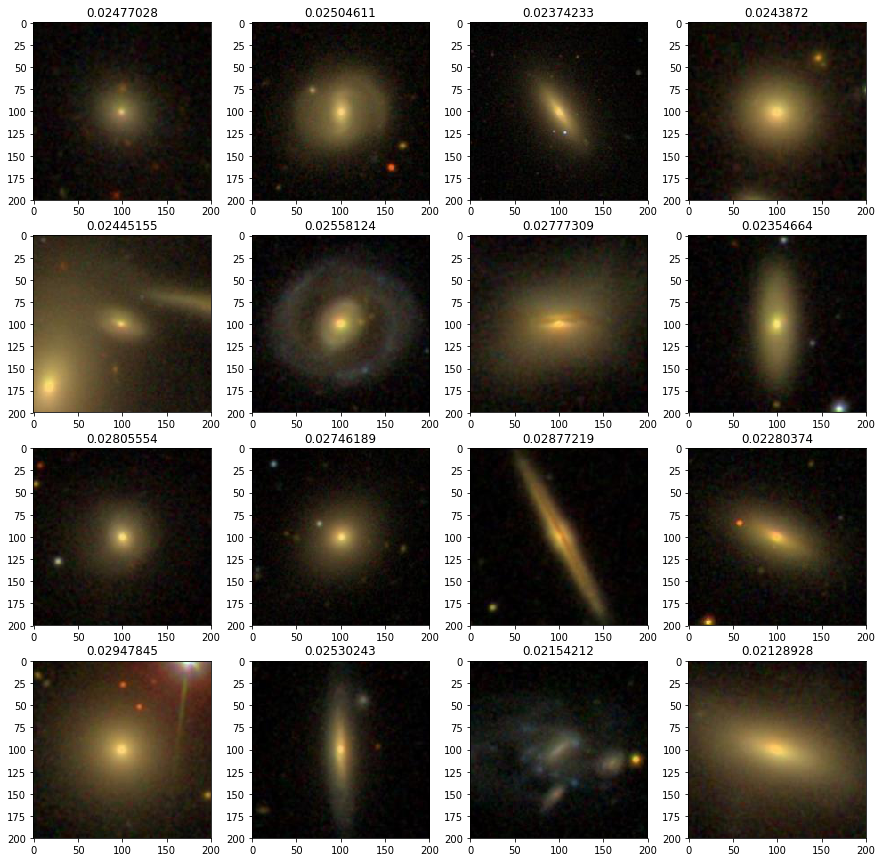

In [15]:
#possible answer
my_galaxies = np.where( (all_gals.z > 0.02) & (all_gals.z < 0.03) & (all_gals['u'] - all_gals['g'] > high_umg))[0]

show_galaxy_images(my_galaxies)

### Exercise:

Repeat the above exercise, now with blue galaxies. Repeat your classification exercise.

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


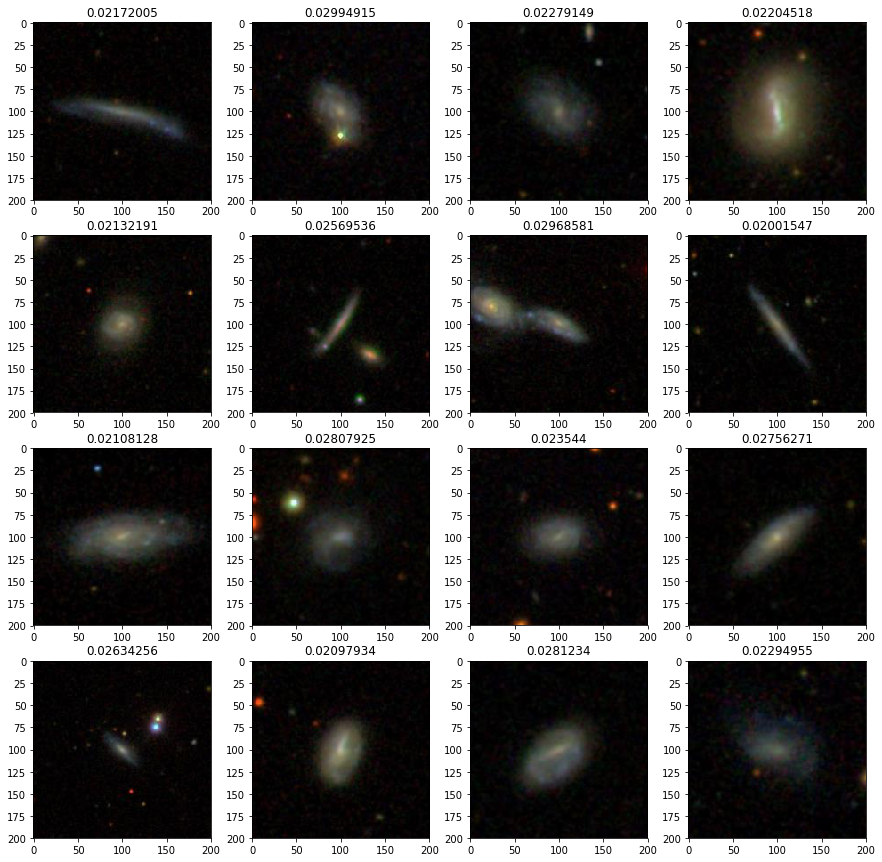

In [16]:
#possible answer
my_galaxies = np.where( (all_gals.z > 0.02) & (all_gals.z < 0.03) & (all_gals['u'] - all_gals['g'] < low_umg))[0]

show_galaxy_images(my_galaxies)

### Exercise:

From the above exercise, what can you say - if anything - about the relationship between colour and morphology?

Possible answer: Most blue galaxies are disc-like. Most red galaxies are bulge-dominated.

## Morphology and environment

Finally, we will explore the **relationship between morphology and environment**. It is extraordinarily difficult to write a computer programme that determines whether a galaxy has spiral structure or is smooth. To this day, the human eye does better than the most sophisticated algorithms (the reason behind projects such as Galaxy Zoo - https://www.galaxyzoo.org). We will use a very simple proxy for morphology, which is good enough for our purposes: the sersic index. The sersic index tells us how rapidly the light profile of a galaxy is falling from the center, and essentially classifies galaxies' light profiles as being very centrally concentrated (like ellipticals), or as being flatter (like spirals). 

The cell below repeats our initial SQL query, but now it also returns the sersic profile, called sersic_n, and we are already limiting the redshift range to be between 0.02 and 0.03.

In [17]:
query="""
SELECT p.objId, p.ra,p.dec,p.petror90_r, p.expAB_r,
    p.dered_u as u, p.dered_g as g, p.dered_r as r, p.dered_i as i, 
    s.z, s.plate, s.mjd, s.fiberid, n.sersic_n
FROM galaxy AS p
   JOIN SpecObj AS s ON s.bestobjid = p.objid
   JOIN nsatlas AS n ON n.mjd = s.mjd and n.fiberID = s.fiberID and n.plate = s.plate
WHERE p.petror90_r > 10
  and p.ra between 100 and 250
  and s.z between 0.02 and 0.03
  and p.g < 17
"""
all_gals = CasJobs.executeQuery(query, "dr14")
print(" Query returns " + str(len(all_gals))+ " galaxies")

 Query returns 7869 galaxies



Below is a histogram of the values of the sersic index in our sample. Let us call galaxies with a very high sersic index ellipticals (n > 4), and a very low sersic index spirals (n < 2).

Text(0.5,1,'Distribution of Sersic index values')

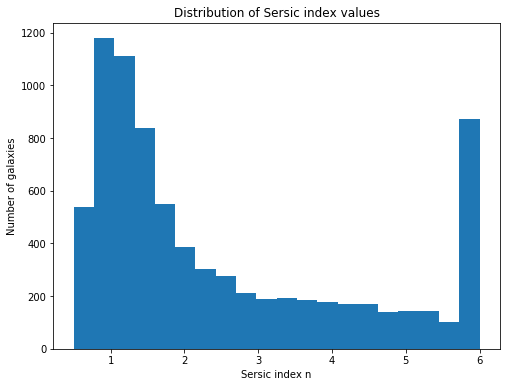

In [18]:
plt.figure(figsize=(8,6))
plt.hist(all_gals['sersic_n'], bins=20)
plt.xlabel('Sersic index n')
plt.ylabel('Number of galaxies')
plt.title('Distribution of Sersic index values')

### Exercise:

Look at the morphologies of high and low sersic index galaxies, like you did for blue and red. In your opinion, how good is this number at identifying morphology?

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


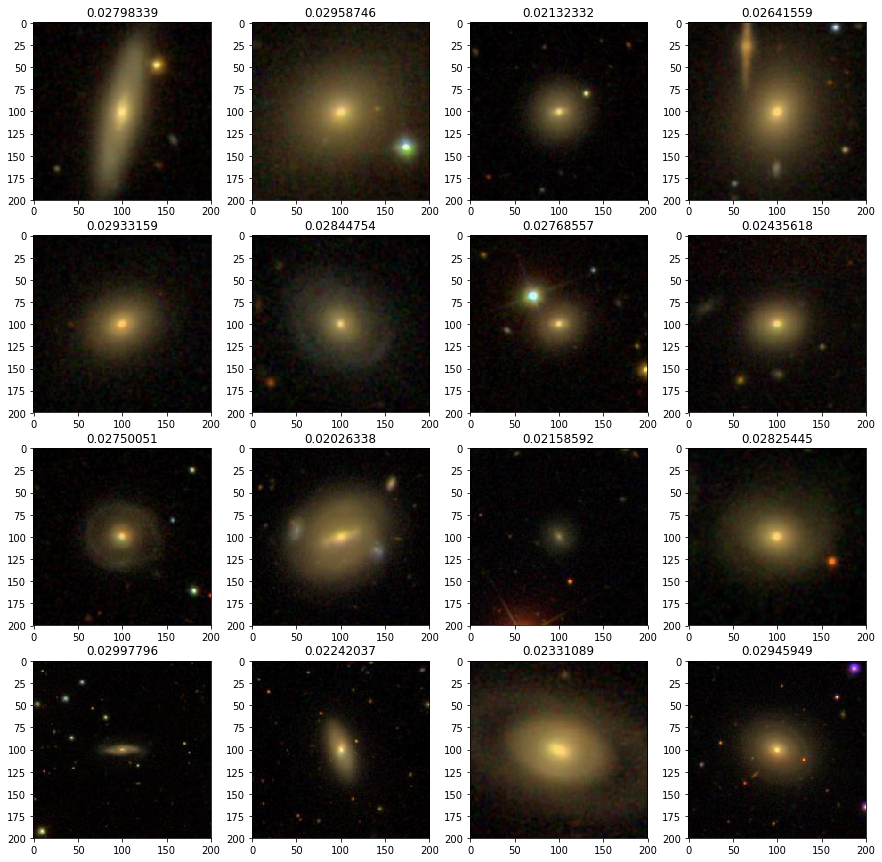

In [19]:
#possible answer
my_galaxies = np.where( (all_gals['sersic_n'] > 4))[0]

show_galaxy_images(my_galaxies)    

Getting image 1 of 16...
Getting image 2 of 16...
Getting image 3 of 16...
Getting image 4 of 16...
Getting image 5 of 16...
Getting image 6 of 16...
Getting image 7 of 16...
Getting image 8 of 16...
Getting image 9 of 16...
Getting image 10 of 16...
Getting image 11 of 16...
Getting image 12 of 16...
Getting image 13 of 16...
Getting image 14 of 16...
Getting image 15 of 16...
Getting image 16 of 16...
Plotting images...


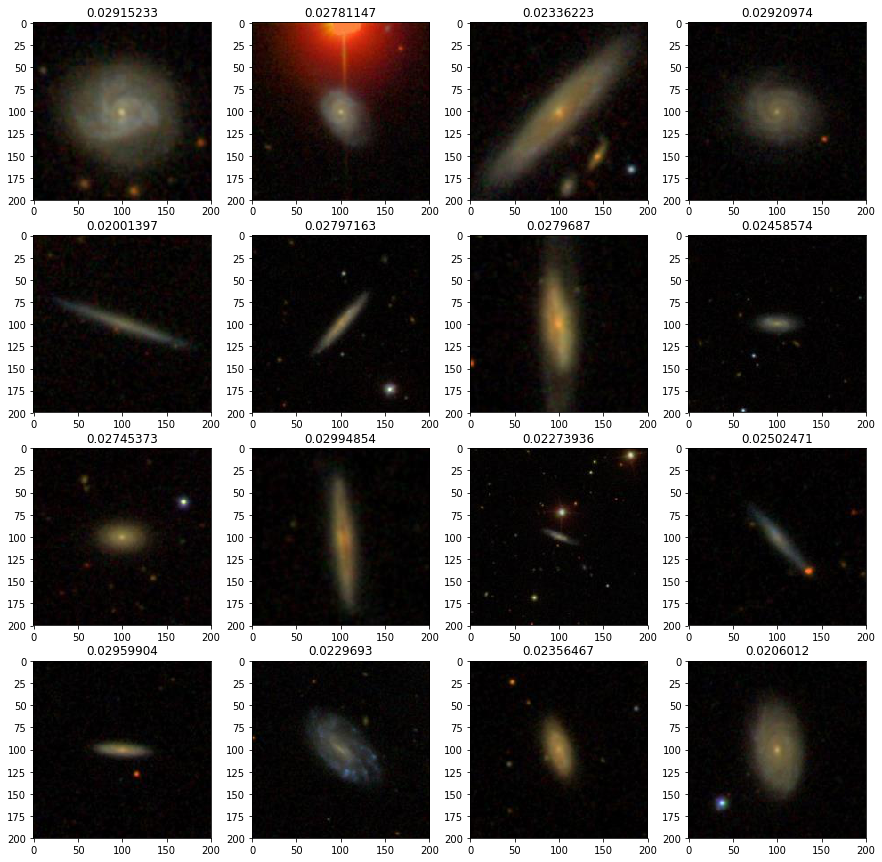

In [20]:
#possible answer
my_galaxies = np.where( (all_gals['sersic_n'] < 1))[0]

show_galaxy_images(my_galaxies)

Answer:

### Exercise:

Now plot the positions of low and high sersic index galaxies, side by side as you did for blue and red galaxies. In your opinion, do you have enough information to determine what property galaxy density influences the most (colour or morphology)? You are encouraged to experiment with different definitions of colour and morphology if you wish, or indeed make an argument as to why your exploration is insuffiencent to answer such a question. 

(-5, 70)

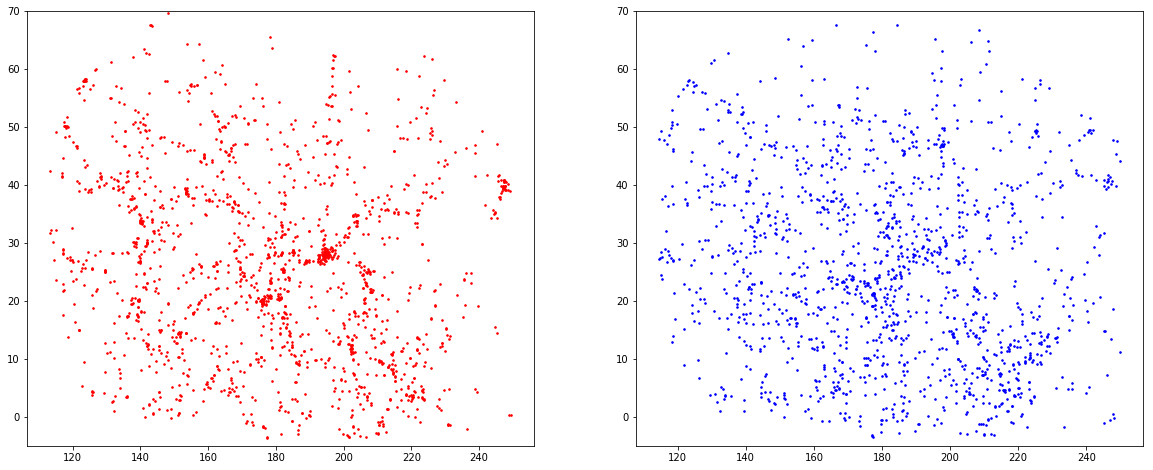

In [21]:
#possible answer
my_galaxies_ell = np.where( (all_gals['sersic_n'] > 4))[0]
my_galaxies_sp = np.where( (all_gals['sersic_n'] < 1))[0]

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(all_gals.loc[my_galaxies_ell]['ra'], all_gals.loc[my_galaxies_ell]['dec'],  marker='.', s=10, color='red')
plt.ylim(-5,70)

plt.subplot(122)
plt.scatter(all_gals.loc[my_galaxies_sp]['ra'], all_gals.loc[my_galaxies_sp]['dec'],  marker='.', s=10, color='blue')
plt.ylim(-5,70)

**Congratulations, that is the end of the Lab!** Make sure you've **run all the code cells, filled in all the text answers and that your plots are all showing without error**. **Print** out the notebook, and **attach it to your lab book**. This account on SciServer is yours to keep, and you're welcome to explore further at any time. If you do, and you ever need some guidance, I would be more than happy to help.